In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt  # standard Python plotting library
import tdt # import the tdt library

In [47]:
# Must read with "/" not "\"
BLOCK_PATH = r'C:\Users\yongc\Desktop\Photometry\Pilot 2\day1\day1\n1-240611-091131'
data = tdt.read_block(BLOCK_PATH)

Found Synapse note file: C:\Users\yongc\Desktop\Photometry\Pilot 2\day1\day1\n1-240611-091131\Notes.txt
read from t=0s to t=2042.14s


In [48]:
time = np.linspace(1,len(data.streams[DA].data), len(data.streams[DA].data))/data.streams[DA].fs
print(time[-1])

2042.080747638385


### Data Info

In [49]:
data.info

tankpath:	'C:\\Users\\yongc\\Desktop\\Photometry\\Pilot 2\\day1\\day1'
blockname:	'n1-240611-091131'
start_date:	datetime.datetime(2024, 6, 11, 12, 11, 36, 999999)
utc_start_time:	'12:11:36'
stop_date:	datetime.datetime(2024, 6, 11, 12, 45, 39, 141958)
utc_stop_time:	'12:45:39'
duration:	datetime.timedelta(seconds=2042, microseconds=141959)
stream_channel:	0
snip_channel:	0
experiment:	'06_12_24_RTC_P2'
subject:	'n1'
user:	'User'
start:	'9:11:37am 06/11/2024'
stop:	'9:45:39am 06/11/2024'

# Basic Plotting and Artifact Removal

In [50]:
#Jupyter has a bug that requires import of matplotlib outside of cell with matplotlib inline magic to properly apply rcParams

import matplotlib
matplotlib.rcParams['font.size'] = 18 # set font size for all figures

# Make some variables up here to so if they change in new recordings you won't have to change everything downstream
ISOS = '_405A' # 405nm channel.
DA = '_465A'
LICK = 'Ler_'

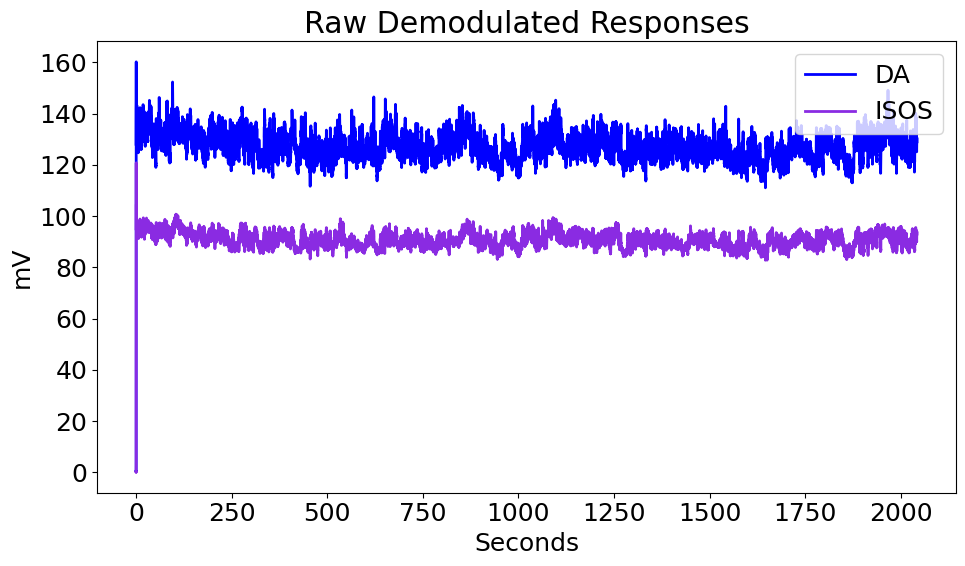

In [51]:
# Make a time array based on the number of samples and sample freq of 
# the demodulated streams
time = np.linspace(1,len(data.streams[DA].data), len(data.streams[DA].data))/data.streams[DA].fs

# Plot both unprocessed demodulated stream            
fig1 = plt.figure(figsize=(10,6))
ax0 = fig1.add_subplot(111)

# Plotting the traces
p1, = ax0.plot(time, data.streams[DA].data, linewidth=2, color='blue', label='DA')
p2, = ax0.plot(time, data.streams[ISOS].data, linewidth=2, color='blueviolet', label='ISOS')

ax0.set_ylabel('mV')
ax0.set_xlabel('Seconds')
ax0.set_title('Raw Demodulated Responses')
ax0.legend(handles=[p1,p2], loc='upper right')
fig1.tight_layout()

# Jupyter for some reason (sometimes) shows the figure without be called, 
# Likely when plt.figure() is called
# otherwise you would call fig in a line by itself like:
# fig


## Artifact Removal

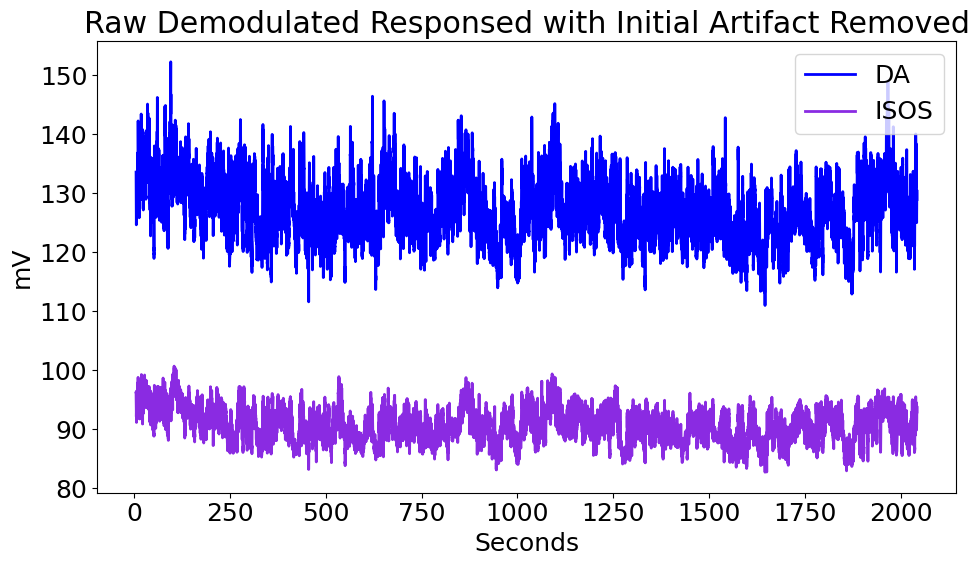

In [52]:
# There is often a large artifact on the onset of LEDs turning on
# Remove data below a set time t
t = 5
inds = np.where(time>t)
ind = inds[0][0]
time = time[ind:] # go from ind to final index
data.streams[DA].data = data.streams[DA].data[ind:]
data.streams[ISOS].data = data.streams[ISOS].data[ind:]

# Plot again at new time range
fig2 = plt.figure(figsize=(10, 6))
ax1 = fig2.add_subplot(111)

# Plotting the traces
p1, = ax1.plot(time,data.streams[DA].data, linewidth=2, color='blue', label='DA')
p2, = ax1.plot(time,data.streams[ISOS].data, linewidth=2, color='blueviolet', label='ISOS')

ax1.set_ylabel('mV')
ax1.set_xlabel('Seconds')
ax1.set_title('Raw Demodulated Responsed with Initial Artifact Removed')
ax1.legend(handles=[p1,p2],loc='upper right')
fig2.tight_layout()
# fig

# Downsample Data Doing Local Averaging

In [57]:
# Average around every Nth point and downsample Nx
N = 10 # Average every 10 samples into 1 value
F405 = []
F465 = []

for i in range(0, len(data.streams[DA].data), N):
    F465.append(np.mean(data.streams[DA].data[i:i+N-1])) # This is the moving window mean
data.streams[DA].data = F465

for i in range(0, len(data.streams[ISOS].data), N):
    F405.append(np.mean(data.streams[ISOS].data[i:i+N-1]))
data.streams[ISOS].data = F405

#decimate time array to match length of demodulated stream
time = time[::N] # go from beginning to end of array in steps on N
time = time[:len(data.streams[DA].data)]

# Detrending and dFF
# Full trace dFF according to Lerner et al. 2015
# https://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline

x = np.array(data.streams[ISOS].data)
y = np.array(data.streams[DA].data)
bls = np.polyfit(x, y, 1)
Y_fit_all = np.multiply(bls[0], x) + bls[1]
Y_dF_all = y - Y_fit_all

dFF = np.multiply(100, np.divide(Y_dF_all, Y_fit_all))
std_dFF = np.std(dFF)

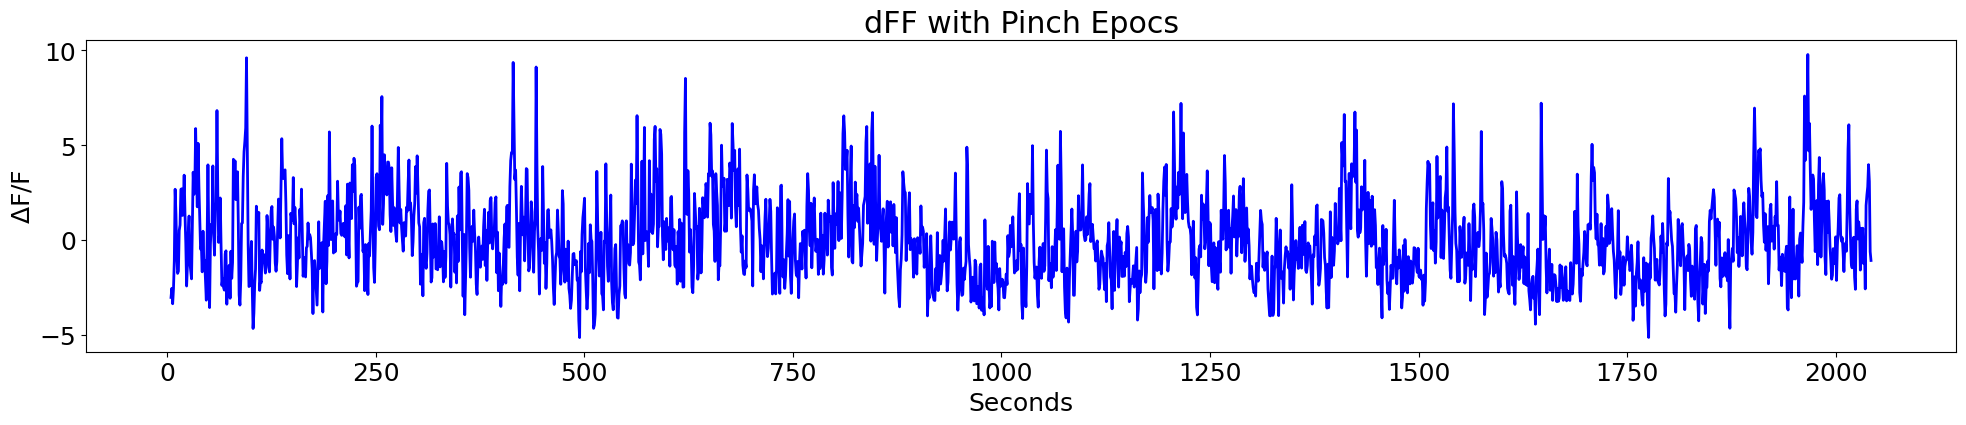

In [58]:
y_scale = 5 #adjust according to data needs
y_shift = -5 #scale and shift are just for aesthetics

# First subplot in a series: dFF with lick epocs
fig3 = plt.figure(figsize=(20,12))
ax2 = fig3.add_subplot(311)

p1, = ax2.plot(time, dFF, linewidth=2, color='blue', label='DA')

ax2.set_ylabel(r'$\Delta$F/F')
ax2.set_xlabel('Seconds')
ax2.set_title('dFF with Pinch Epocs')
fig3.tight_layout()

## Make nice area fills instead of epocs for aesthetics

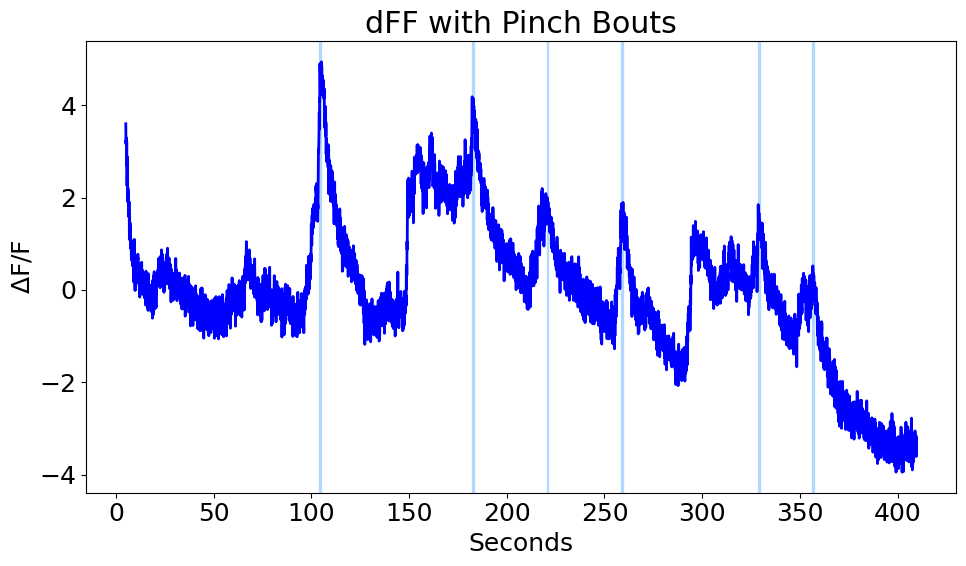

In [16]:
fig4 = plt.figure(figsize=(10,6))
ax5 = fig4.add_subplot(111)

p1, = ax5.plot(time, dFF,linewidth=2, color='blue', label='DA')
for on, off in zip(data.epocs[PINCH_EVENT].onset, data.epocs[PINCH_EVENT].offset):
    ax5.axvspan(on, off, alpha=0.25, color='dodgerblue')
ax5.set_ylabel(r'$\Delta$F/F')
ax5.set_xlabel('Seconds')
ax5.set_title('dFF with Pinch Bouts')
fig4.tight_layout()

# Time Filter Around Pinch Bout Epocs

In [14]:
PRE_TIME = 5 # five seconds before event onset
POST_TIME = 5 # ten seconds after
fs = data.streams[DA].fs/N #recall we downsampled by N = 10 earlier

# time span for peri-event filtering, PRE and POST, in samples
TRANGE = [-PRE_TIME*np.floor(fs), POST_TIME*np.floor(fs)]

dFF_snips = []
array_ind = []
pre_stim = []
post_stim = []

for on in data.epocs[PINCH_EVENT].onset:
    # If the bout cannot include pre-time seconds before event, make zero
    if on < PRE_TIME:
        dFF_snips.append(np.zeros(TRANGE[1]-TRANGE[0]))
    else: 
        # find first time index after bout onset
        array_ind.append(np.where(time > on)[0][0])
        # find index corresponding to pre and post stim durations
        pre_stim.append(array_ind[-1] + TRANGE[0])
        post_stim.append(array_ind[-1] + TRANGE[1])
        dFF_snips.append(dFF[int(pre_stim[-1]):int(post_stim[-1])])

# Make all snippets the same size based on min snippet length
min1 = np.min([np.size(x) for x in dFF_snips])
dFF_snips = [x[1:min1] for x in dFF_snips]

mean_dFF_snips = np.mean(dFF_snips, axis=0)
std_dFF_snips = np.std(mean_dFF_snips, axis=0)

peri_time = np.linspace(1, len(mean_dFF_snips), len(mean_dFF_snips))/fs - PRE_TIME


# Make a Peri-Event Stimulus Plot and Heat Map

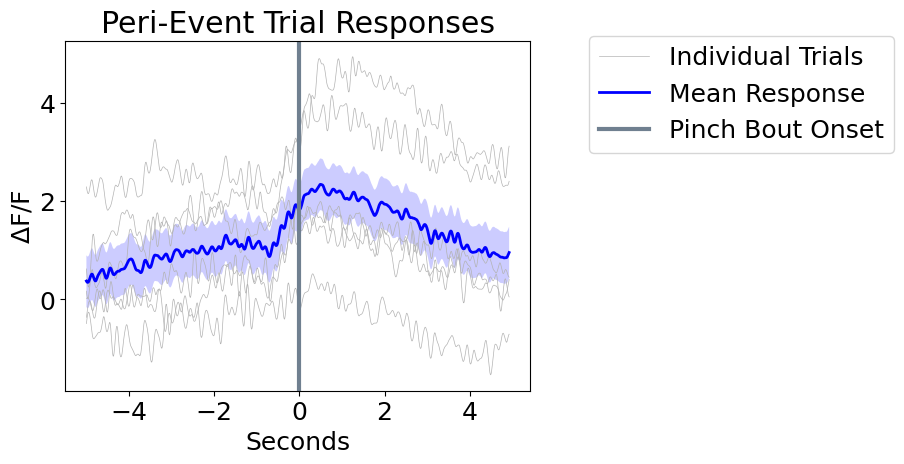

In [15]:
fig5 = plt.figure(figsize=(6,10))
ax6 = fig5.add_subplot(211)

for snip in dFF_snips:
    p1, = ax6.plot(peri_time, snip, linewidth=.5, color=[.7, .7, .7], label='Individual Trials')
p2, = ax6.plot(peri_time, mean_dFF_snips, linewidth=2, color='blue', label='Mean Response')

# Plotting standard error bands
p3 = ax6.fill_between(peri_time, mean_dFF_snips+std_dFF_snips, 
                      mean_dFF_snips-std_dFF_snips, facecolor='blue', alpha=0.2)
p4 = ax6.axvline(x=0, linewidth=3, color='slategray', label='Pinch Bout Onset')

ax6.axis('tight')
ax6.set_xlabel('Seconds')
ax6.set_ylabel(r'$\Delta$F/F')
ax6.set_title('Peri-Event Trial Responses')
ax6.legend(handles=[p1, p2, p4], bbox_to_anchor=(1.1, 1.05));